In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('RSCCASN.csv')

In [3]:
df.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
DATE       334 non-null object
RSCCASN    334 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [5]:
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
RSCCASN    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [7]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [8]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

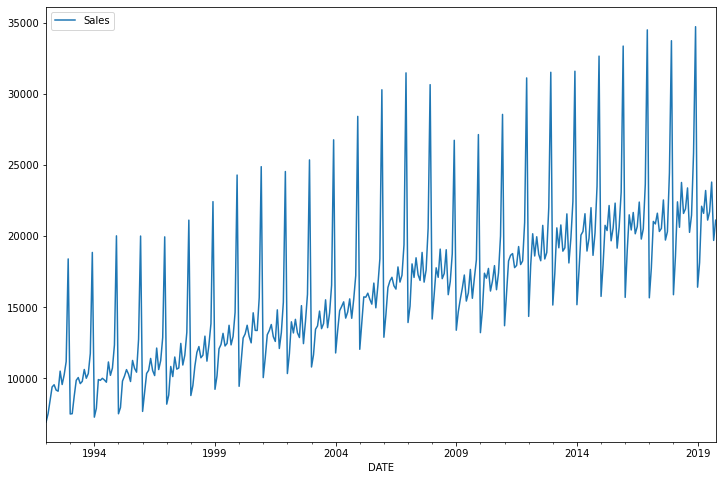

In [9]:
df.plot(figsize = (12,8))


In [10]:
len(df)

334

In [11]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [12]:
len(df) - 18

316

In [13]:
test_size = 18
test_ind = len(df) - test_size

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [16]:
train.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [17]:
test.head()

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# batch size should be less than the test size
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size= 1)

In [20]:
X,y = generator[0]

In [21]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [22]:
y

array([[0.02047633]])

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
n_features = 1

In [25]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience = 2)

In [29]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [30]:
model.fit_generator(generator,epochs = 20, validation_data= validation_generator, callbacks = [early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0239 - val_loss: 0.0175
Epoch 2/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0149 - val_loss: 0.0082
Epoch 3/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 4/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0084 - val_loss: 0.0015
Epoch 5/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 6/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 7/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 3.1321e-04
Epoch 8/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0019 - val_loss: 2.3976e-04
Epoch 9/20
304/304 [===

In [34]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

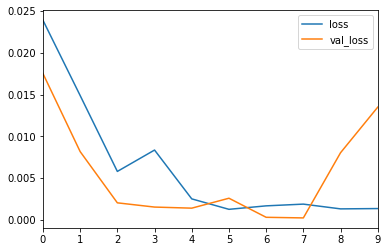

In [35]:
losses.plot()

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)


In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test['predctions'] = true_predictions

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
test.head()

,Sales,predctions
DATE,,
2018-05-01,23764,24403.143648
2018-06-01,21589,23288.313083
2018-07-01,21919,23552.869657
2018-08-01,23381,25322.632192
2018-09-01,20260,22985.538202


<AxesSubplot:xlabel='DATE'>

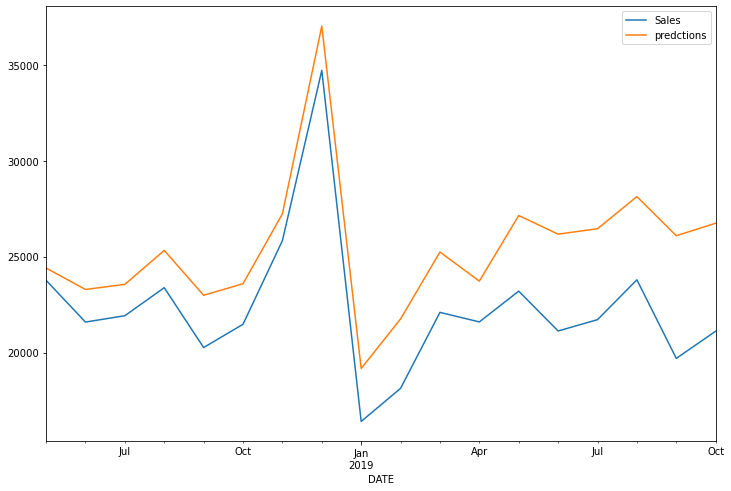

In [40]:
test.plot(figsize = (12,8))

In [41]:
full_scaler = MinMaxScaler()
scaled_fulldata = full_scaler.fit_transform(df)

In [42]:
length = 12
generator = TimeseriesGenerator(scaled_fulldata, scaled_fulldata, length=length, batch_size=1)

In [44]:
model = Sequential ()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs = 8)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 5s 14ms/step - loss: 0.0245
Epoch 2/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0145
Epoch 3/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0075
Epoch 4/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0033
Epoch 5/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0035
Epoch 6/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0019
Epoch 7/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0024
Epoch 8/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0021


In [47]:
forecast = []
periods = 12
first_eval_batch = scaled_fulldata[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range((periods)):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [48]:
forecast = scaler.inverse_transform(forecast)

In [49]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [50]:
forecast

array([[26605.10845089],
       [37335.23731041],
       [17594.19673753],
       [19109.94683933],
       [22376.07450867],
       [21980.26327848],
       [23501.41227627],
       [21669.71142673],
       [22258.68607616],
       [24159.79520464],
       [20675.97636604],
       [22033.1801753 ]])

In [51]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq='MS')

In [52]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [53]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [54]:
forecast_df

,Forecast
2019-11-01,26605.108451
2019-12-01,37335.237310
2020-01-01,17594.196738
2020-02-01,19109.946839
2020-03-01,22376.074509
2020-04-01,21980.263278
2020-05-01,23501.412276
2020-06-01,21669.711427
2020-07-01,22258.686076
2020-08-01,24159.795205


<AxesSubplot:>

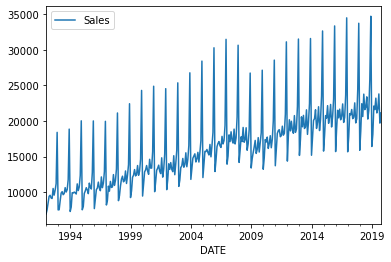

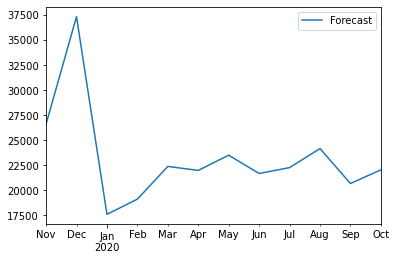

In [55]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

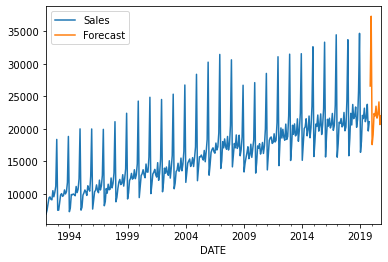

In [58]:
ax = df.plot()
forecast_df.plot(ax = ax)
plt.xlim('2018-01-01', '2020-12-01')

(576.0, 611.0)

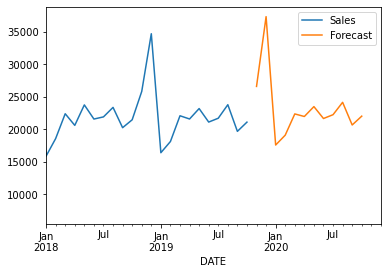

In [59]:
ax = df.plot()
forecast_df.plot(ax = ax)
plt.xlim('2018-01-01', '2020-12-01') 